In [1]:
import sys

sys.path.append("../src")

# Quickstart 3: Using your own datasets

Now that we've seen how to use the example datasets in `functional_autoencoders.datasets`, you might like to try FVAE/FAE with your own data.
This notebook shows how to set up efficient data-loading code to:

- generate datasets programmatically; or
- load data from disk.

We'll just show how to create the `dataset` objects here, but you can wrap any of these datasets in `get_dataloaders` as we saw in the previous two notebooks. 
The dataset objects we use are based on the [PyTorch dataloader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) code, which handles the technical details of retreiving data efficiently.


## Generating datasets programmatically with `GenerableDataset`

In [2]:
import numpy as np
from functional_autoencoders.datasets import GenerableDataset


class CustomProgrammaticallyGeneratedDataset(GenerableDataset):
    def __init__(
        self,
        samples=48,
        pts=128,
        transform=None,
        *args,
        **kwargs,
    ):
        self.transform = transform
        self.samples = samples
        self.pts = pts
        super().__init__(*args, **kwargs)

    def generate(self):
        x = np.linspace(0, 1, self.pts + 2)[1:-1]
        frequencies = np.random.randint(0, 20, (self.samples,)) * np.pi
        frequencies = np.expand_dims(frequencies, -1)
        u = np.sin(frequencies * x)
        x = np.expand_dims(x, -1)
        self.data = {
            "u": u,
            "x": x,
        }

    @property
    def x(self):
        return self.data["x"][:]

    def __len__(self):
        return self.data["u"].shape[0]

    def __getitem__(self, idx):
        u = self.data["u"][idx]
        x = self.data["x"][:]
        if self.transform is not None:
            return self.transform(u, x)
        else:
            return u, x, u, x

Let's visualize a sample from this dataset to see whether everything worked.

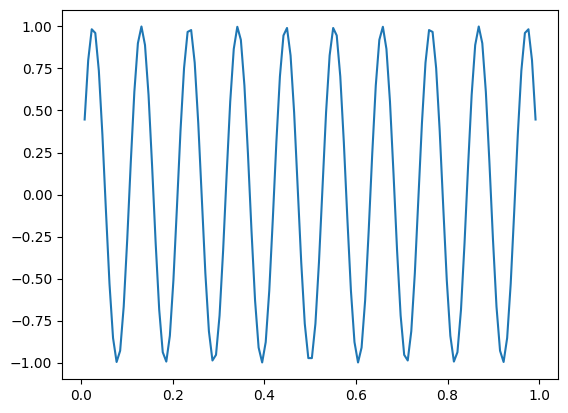

In [3]:
import matplotlib.pyplot as plt

dataset = CustomProgrammaticallyGeneratedDataset()
u_enc, x_enc, u_dec, x_dec = dataset[0]
plt.plot(x_enc, u_enc)

## Loading data from disk

We provide a helper class, `OnDiskDataset`, which we use for all of the downloadable datasets included with `functional_autoencoders`, which you're free to use in your code too.
You could use any file format you like, e.g., `.h5`, `.npy`, `.npz`, or `.mat`, and you'll need to take care of loading the datasets yourself.

To illustate this, we'll load a `.npz` file from the disk. Just for the purposes of illustration, we'll use the data we already generated from the previous dataset to generate the `.npz` file (but in practical applications, the `.npz` file could have come from some other simulation, for example).

In [4]:
import os

os.makedirs("./data/custom_on_disk_data", exist_ok=True)
np.savez(
    "./data/custom_on_disk_data/data.npz", u=dataset.data["u"], x=dataset.data["x"]
)

Now the file exists on the disk, let's use an `OnDiskDataset` to load it!

In [5]:
from functional_autoencoders.datasets import OnDiskDataset


class CustomOnDiskDataset(OnDiskDataset):
    dataset_name = "custom_on_disk_data"
    dataset_filename = "data.npz"

    def __init__(self, transform=None, data_base=".", *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_base = data_base
        self.transform = transform
        self.data = np.load(self.dataset_path, allow_pickle=True)

    def __getitem__(self, idx):
        u = self.data["u"][idx]
        x = self.data["x"]

        if self.transform is not None:
            return self.transform(u, x)
        else:
            return u, x, u, x

Loading the dataset from disk and visualizing a sample gives the expected result, showing all is good.

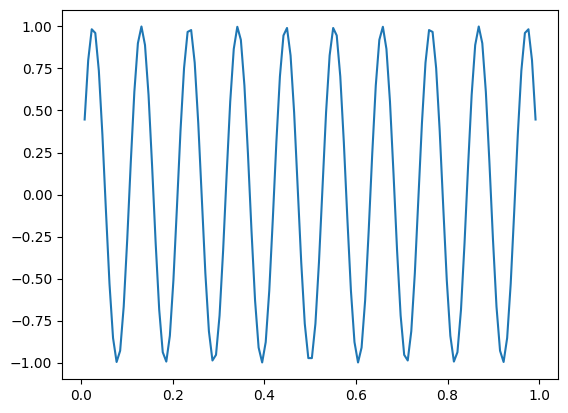

In [6]:
dataset = CustomOnDiskDataset()
u_enc, x_enc, u_dec, x_dec = dataset[0]
plt.plot(x_enc, u_enc)

## What next?

Now you've set up your own dataset with the built-in FVAE and FAE models, you can:

- swap the default encoder and decoder for custom architectures ([`quickstart/4_Custom_Architectures.ipynb`](./4_Custom_Architectures.ipynb)).